<a href="https://colab.research.google.com/github/ksapru/BU-SocialSentiment583/blob/main/Sentiment_Analysis_With_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Example CNN for Audio

In this notebook, we will show how to create a simple CNN for
audio classification, using the spoken digits database. 

An excellent resource for CNNs is chapter 14 of "Hands-on Machine Learning...." by Geron:

https://www.knowledgeisle.com/wp-content/uploads/2019/12/2-Aur%C3%A9lien-G%C3%A9ron-Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-Tensorflow_-Concepts-Tools-and-Techniques-to-Build-Intelligent-Systems-O%E2%80%99Reilly-Media-2019.pdf



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import librosa, librosa.display
from IPython.display import Audio
import os

from google.colab import drive
drive.mount('/content/drive')

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from scipy import signal

from scipy.signal import find_peaks

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
#import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)  

# normalize a signal so that its max = 1.0

def normalize(x):
    return x / max(abs(x))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=None):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if((sr == None) or (fileSR == sr)):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 

# write signal array out to a file in your local directory (or to complete path name)

def writeSignal(name,data,sr=SR):
    sf.write(name,data,sr)

In [ ]:
# Display 


def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()
    
# test

# f = 10
# X = makeSignal([(10,1,0)])
# displaySignal(X,gridlines=True)

# displaySignal(X,x_units="Samples")

# displaySignal(X,x_units="Milliseconds")

In [ ]:
# Amplitude-based onset detection

# The energy in a window is the mean of the squared amplitudes

def energy(x):
    return (x @ x) / len(x)

# Half-wave rectification

def rectify(x):
    if(isinstance(x,np.ndarray)):
        return np.maximum(x,np.zeros(len(x)))
    elif(isinstance(x,list)):
        return list(np.maximum(x,np.zeros(len(x))))
    else:
        return max(x,0)

def AmplitudeBasedOnsets(X,window_size=512,hop_length=256,scale=10,
                         height=None,
                         prominence=None,
                         distance=None,
                         displayAll=False):
    
    N = len(X)
    
    X = X / max(X)       # normalize amplitude

    num_windows = (N // hop_length) - 1
    window_locations = hop_length * np.arange(num_windows)
    X_energy = np.array( [ energy( X[ w : (w+window_size)] ) for w in window_locations ])
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Signal")
        plt.plot(X_energy)
        plt.show()

    # take the log with scaling factor
    # if scale = None, don't do the log

    if(scale == None):
        X_energy_log = X_energy
    else:
        X_energy_log = np.log(1 + scale*X_energy)

        if(displayAll):
            plt.figure(figsize=(12,4))
            plt.title("Log X Energy Signal with scale factor "+str(scale))
            plt.plot(X_energy_log)
            plt.show()

    # Difference = Novelty Function
    
    # add 0 at beginning so diff alines with change in new window
    
    X_energy_log = np.concatenate([[0],X_energy_log])    

    # Take the discrete differential; watch out, diff transforms array in place

    X_energy_novelty = np.diff(list(X_energy_log)) 
    
    # standardize novelty
    
    X_energy_novelty = X_energy_novelty / max(X_energy_novelty)
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Novelty")
        plt.plot(X_energy_novelty)
        plt.show()

    X_energy_novelty_rectified = rectify(X_energy_novelty)      
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Rectified X Energy Novelty")
        plt.plot(X_energy_novelty_rectified)
        plt.show()

    # peak picking

    peaks,_ = find_peaks(X_energy_novelty_rectified,
                         height=height,prominence=prominence,distance=distance)   

    if(len(peaks)==0):
        print("No peaks found!")
        return (np.array([]), np.zeros(len(X)))
    
    if(displayAll):    
        plt.figure(figsize=(12,4))
        plt.title("Picking Peaks")
        plt.plot(peaks, X_energy_novelty_rectified[peaks], "or")
        plt.plot(X_energy_novelty_rectified)
        plt.show()
    
    # peaks are beginning of window, more accurate to make the onsets in the middle
    # of the window, reduces potential error by 1/2
    
    onsets = peaks*hop_length + window_size//2
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(X)
        for k in range(len(onsets)):
            plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
        plt.show()
    
    return onsets

In [ ]:
# set up path of project and determine where the audio dataset files are located
curr_path = '/content/drive/My Drive/BU-SocialSentiment583/'

dataset_dir = "audio_full/"

In [ ]:
#Read audio files into sentiment_data

sentiment_data = []
spoken_digit_meta_data = []

#count = 0
for filename in os.listdir(curr_path + dataset_dir):
    if(filename[0] == '.'):      # to avoid hidden files such as .DS_Store
        continue
    X, fileSR = librosa.load(curr_path + dataset_dir+filename)
    if(fileSR != SR):           # error checking, to make sure all signals are SR = 22050
        print("Error:",filename, fileSR)
        
    sentiment_data.append(X)

len(sentiment_data)

FileNotFoundError: ignored

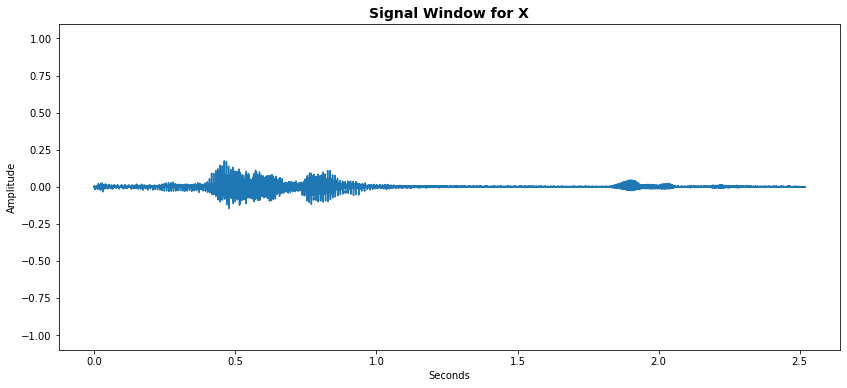

In [ ]:
# test to make sure audio is being read correctly
k = 123
#print(spoken_digit_meta_data[k])
displaySignal(sentiment_data[k])
Audio(sentiment_data[k],rate=fileSR)

### Data exploration 

Looking at some interesting features of our audio data


In [ ]:
# create matrix of features for the classifier

num_features = 7

sentiment_features = np.empty((len(sentiment_data),num_features))

for k in range(len(sentiment_data)):

    y = sentiment_data[k]

    # These functions compute a value for each frame, either from the audio 
    # samples y or from a spectrogram S.

    # By making the hop_length longer than the signal, we just grab the metric 
    # of the whole signal


    RMS = librosa.feature.rms(y,hop_length=len(y)+1)[0][0]
    #print('rms:',RMS)

    SC = librosa.feature.spectral_centroid(y,hop_length=len(y)+1)[0][0]
    #print('spectral_centroid:',SC)

    SB = librosa.feature.spectral_bandwidth(y,hop_length=len(y)+1)[0][0]
    #print('spectral_bandwidth:',SB)

    SCON = librosa.feature.spectral_contrast(y,hop_length=len(y)+1)[0][0]
    #print('spectral_contrast:',SCON)

    SF = librosa.feature.spectral_flatness(y,hop_length=len(y)+1)[0][0]
    #print('spectral_flatness:',SF)

    SR = librosa.feature.spectral_rolloff(y,hop_length=len(y)+1)[0][0]
    #print('spectral_rolloff:',SR)

    ZCR = librosa.feature.zero_crossing_rate(y,hop_length=len(y)+1)[0][0]
    #print('zero_crossing_rate:',ZCR)
    
    sentiment_features[k] = np.array([RMS,SC,SB,SCON,SF,SR,ZCR])

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1412
  n_fft, y.shape[-1]


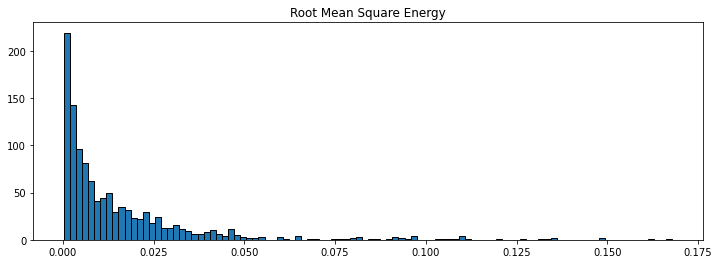

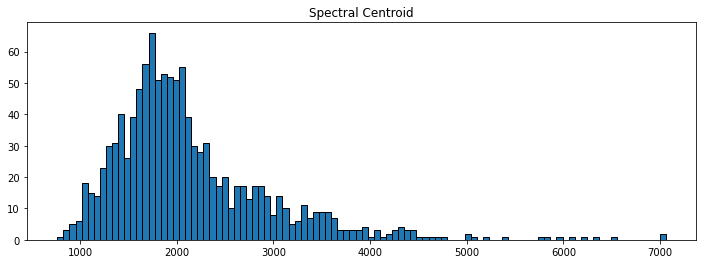

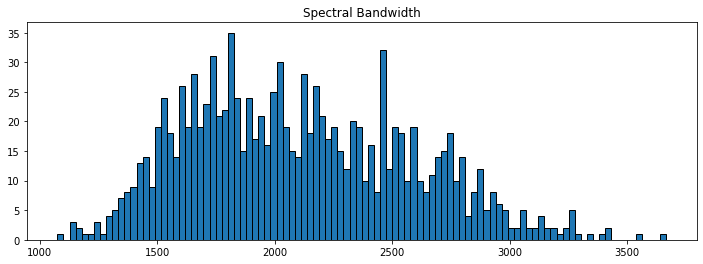

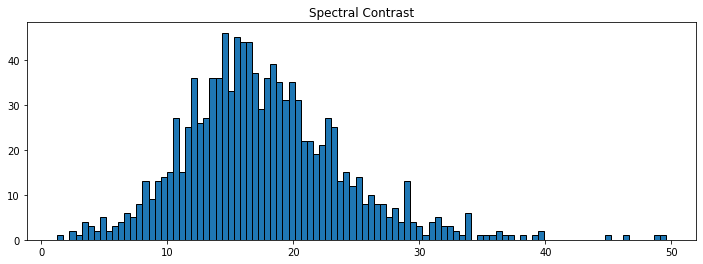

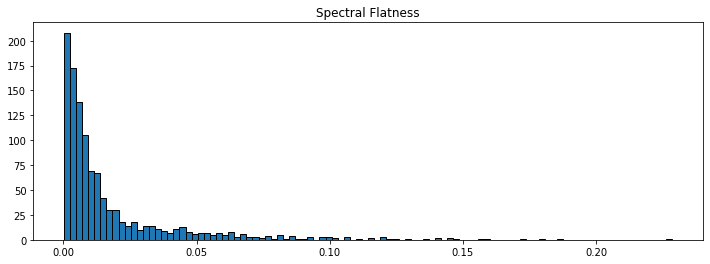

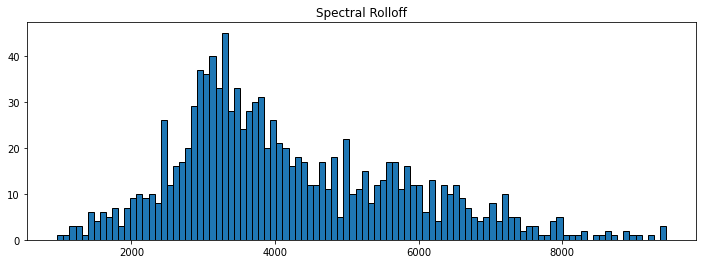

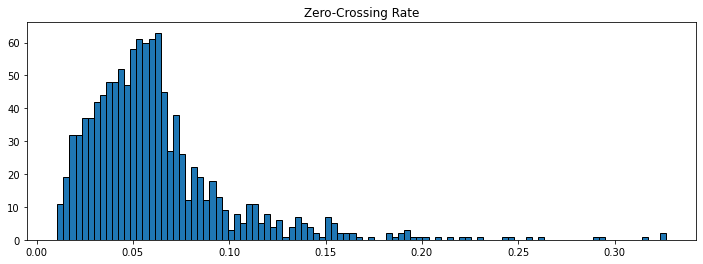

In [ ]:
# Try a histogram of each feature

feature_names = ['Root Mean Square Energy','Spectral Centroid','Spectral Bandwidth','Spectral Contrast',
                 'Spectral Flatness','Spectral Rolloff','Zero-Crossing Rate']

for k in range(num_features):    
    plt.figure(figsize=(12,4))
    plt.title(feature_names[k])
    plt.hist([fs[k] for fs in sentiment_features],bins=100, edgecolor='black')  # This gives the number of different signal lengths in the data set
    plt.show()


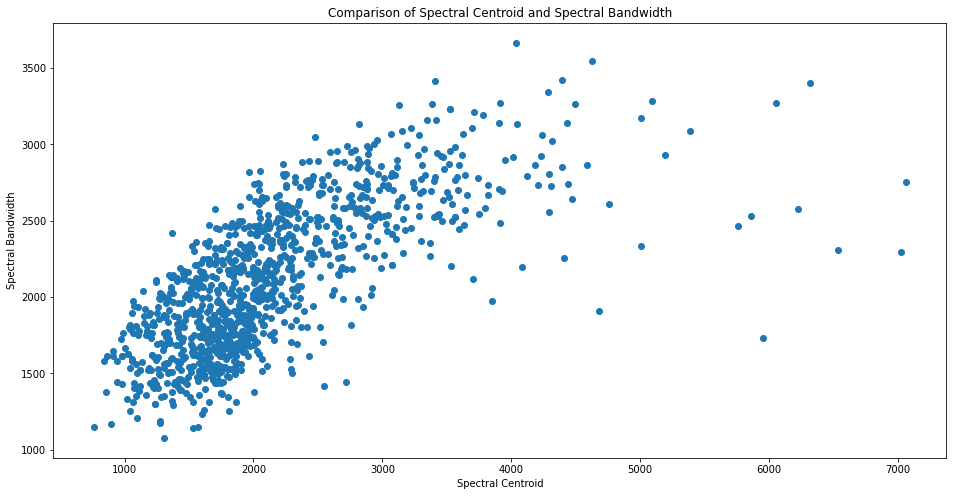

In [ ]:
#Try graphing two at a time

# feature_names = ['Root Mean Square Energy','Spectral Centroid','Spectral Bandwidth','Spectral Contrast',
#                  'Spectral Flatness','Spectral Rolloff','Zero-Crossing Rate']

f1 = 1
f2 = 2

plt.figure(figsize=(16,8))
plt.title("Comparison of "+feature_names[f1]+" and "+feature_names[f2])
plt.scatter([fs[f1] for fs in sentiment_features],[fs[f2] for fs in sentiment_features])
plt.xlabel(feature_names[f1])
plt.ylabel(feature_names[f2])
plt.show()
del(sentiment_features)
del(feature_names)

### Exploring the length of the signals (Important!)

Here, we explore the histogram of our audio files.
We notice that there are few clips that go beyond 200,000 samples. We will keep this in mind for when we trim our audio so that they have uniform sample rates.

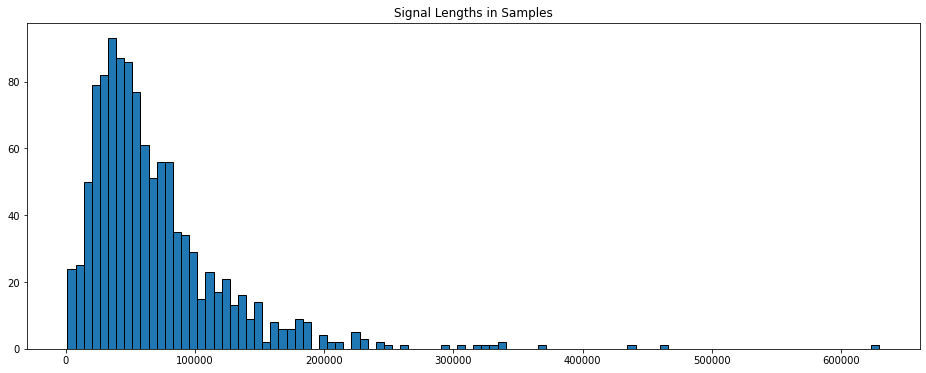

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Signal Lengths in Samples")
plt.hist([len(x) for x in sentiment_data],bins=100, edgecolor='black')  # This gives the number of different signal lengths in the data set
plt.show()

### Normalizing the amplitude and trimming the audio files

We will add 0.25 secs of silence to the beginning and the end of the clip (to avoid problems with
finding onsets at the very beginning of a file, which can be problematic), and then find the onset
and the onset of the reversed signal. Finding the appropriate settings for the parameters in the
onset detector is critical here. 



First we explore the effect of various parameters to the onset detector, and come up with
a reasonable choice for finding the beginning and end of the spoken digit in the signal.  
We will also find the distribution of the resulting lengths, so we can choose a uniform
length for the inputs to the CNN. 


In [ ]:
# AmplitudeBasedOnsets(X,window_size=512,overlap=0.5,scale=10,
#                      height=None, prominence=None, distance=None, 
#                      displayAll=False):

lens = []

for k in range(len(sentiment_data)):                     
    x = sentiment_data[k]
    x1 = np.concatenate([np.zeros(int(SR//4)),normalize(x)])
    onsets = AmplitudeBasedOnsets(x1,window_size=128,hop_length=1, 
                                  scale=100,height=0.01, prominence=0.01,displayAll=False)
    offsets = AmplitudeBasedOnsets(x1[::-1],window_size=128,hop_length=1, 
                                   scale=100,height=0.01, prominence=0.01,displayAll=False)
    
    start = onsets[0]
    end = len(x1) - offsets[0]
    
    lens.append(end-start)
    
    # See example onset detection for our first 5 signals
    if(k in [i for i in range(5)]):
        print(k,start,end)
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(x1)
        plt.plot([start,start],[-1,1],color='r')
        plt.plot([end,end],[-1,1],color='g')
        plt.show()
    
    
plt.figure(figsize=(16,6))
plt.title("Signal Lengths in Samples")
plt.hist(lens,bins=100, edgecolor='black')  # This gives the number of different signal lengths in the data set
plt.show()

NameError: ignored

In [ ]:
#Show that only a few audio clups go beyond our 200,000 sample threshold
new_len = 200000
over = []
for k in range(len(lens)):
    if(lens[k] > new_len):
        #print(spoken_digit_meta_data[k])
        #displaySignal(sentiment_data[k])
        over.append(1)
print(len(over))
del(over)

27


Normalize our data signals and trim them all to 100,000 samples based on detected onset and end of the signal.

In [ ]:
sentiment_data_trimmed = []

for k in range(len(sentiment_data)):                     
    x = sentiment_data[k]
    x1 = np.concatenate([np.zeros(int(SR//4)),normalize(x)])
    onsets = AmplitudeBasedOnsets(x1,window_size=128,hop_length=1, 
                                  scale=100,height=0.01, prominence=0.01,displayAll=False)
    
    start = onsets[0]
    if(len(x1) > start+new_len):              # long enough, just trim
        x2 = x1[start:(start+new_len)]
    else:                                     # not long enough, add zeros to end
        x2 = np.concatenate( [ x1[start:], np.zeros(new_len - len(x1) + start)  ] )
        
    if(len(x2) != new_len):                   # to verify that all are length new_len
        print(k,spoken_digit_meta_data[k])
        break
        
    sentiment_data_trimmed.append(x2)
        

        
len(sentiment_data_trimmed)

### Creating labels for the data set

To label the poisitive or negative sentiment of our data, we will use the labels provided in the CSV of our dataset of positive and negative sentiment and from there, will set the label as 1 if it is positive, and 0 if it is negative. Neutral data is dealt with as 0.5.

In [ ]:
import csv

list_of_rows = []
# read csv file as a list of lists
with open('/content/drive/My Drive/BU-SocialSentiment583/dev_sent_emo.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj)
    # Pass reader object to list() to get a list of lists
    list_of_rows = list(csv_reader)
full_sentiment_meta_data = []
for row in list_of_rows:
  full_sentiment_meta_data.append(row[3:7])
print(full_sentiment_meta_data)
print(len(full_sentiment_meta_data))

### Creating Mel Spectrograms of our audio data



In [ ]:
mel_spectrograms = []
SR = 22050
remove = []
ids = []
sentiment_meta_data = []
sent_ids = []
for x in sentiment_data_trimmed:
    mel_spectrograms.append(librosa.feature.melspectrogram(x,SR,n_fft=512,hop_length=256, power=1))
for i,filename in enumerate(os.listdir(curr_path + dataset_dir)):
    if(filename[0] == '.'):      # to avoid hidden files such as .DS_Store
        continue
    if ')' in filename or ' ' in filename:
      remove.append(i)
      continue
    fns = filename.split('_')
    dia = fns[0][3:]
    #utt=0
    #if len(fns[1]) > 8 and fns([1][-8]) == ')':
    #  utt = int(fns([1][3:-12]))
    utt = fns[1][3:-8]
    ids.append((utt,dia))
    #for s in sentiment_meta_data[1:]:
    #  if int(s[2]) == dia and int(s[3]) == utt:
    #    _,sent,_,_ = s
    #    if sent == "positive":
    #      labels.append(0)
    #    elif sent == "negative":
    #      labels.append(1)
    #    else:
    #      labels.append(.5)
    #    break
for s in full_sentiment_meta_data:
  sent_ids.append((s[3],s[2]))
print(len(ids))
for (utt, dia) in ids:
  for s in full_sentiment_meta_data:
    if s[2] == dia and s[3] == utt:
      sentiment_meta_data.append(s)
for i,tup in enumerate(ids):
  if tup not in sent_ids:
    remove.append(i)
print(len(sentiment_meta_data))
remove.reverse()
for i in remove:
  mel_spectrograms.pop(i)
a = mel_spectrograms

mel_spectrograms = np.asarray(mel_spectrograms)

b = mel_spectrograms 

mel_spect_shape = list(mel_spectrograms.shape)
mel_spect_shape.append(1)

mel_spectrograms = mel_spectrograms.reshape(mel_spect_shape)
mel_spectrograms.shape
del(full_sentiment_meta_data)
del(sentiment_data_trimmed)
del(sentiment_data)

Check the shape of our mel spectrogram. Keep this for reference later for when we feed our spectrograms into our CNN

In [ ]:
mel_spect_shape


In [ ]:
for i in range(15):
    plt.figure()
    librosa.display.specshow(mel_spectrograms[i].reshape(mel_spect_shape[1:-1]),
                             y_axis='mel', x_axis='time')
    plt.title('Mel Spectrogram')
    plt.colorbar()

In [ ]:
# match csv entries with audio clips
labels = []
remove = []
for s in sentiment_meta_data:
    _,sent,_,_ = s
    if sent == "positive":
      labels.append(0)
    elif sent == "negative":
      labels.append(1)
    else:
      labels.append(.5)
labels = np.array(labels)

print(labels[:10])
len(labels)

## Separating Test Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(mel_spectrograms, labels, test_size=0.20, random_state=42)

X_valid,X_train = X_train_full[:30],X_train_full[30:]    # see p.298 in "Hands-On..."
y_valid,y_train = y_train_full[:30],y_train_full[30:]

In [ ]:
X_train_full.shape

In [ ]:
X_train.shape

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

In [ ]:
y_train_full.shape

In [ ]:
y_train.shape

In [ ]:
y_valid.shape

In [ ]:
y_test.shape

## Model Creation

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

In [ ]:
mel_spect_shape[1:]

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu", padding="same",input_shape=[128, 782, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)
prediction_list = []
for pred in y_pred:
  predictions = []
  for p in pred:
    if p < .5:
      predictions.append("negative")
    else:
      predictions.append("positive")
  prediction_list.append(predictions)
print(prediction_list)

In [ ]:
#Test on real new data
X, fileSR = librosa.load(curr_path + "test_clips/test_clip.wav")
X = X[:new_len]
mels = []
mel = librosa.feature.melspectrogram(X,SR,n_fft=512,hop_length=256, power=1)
librosa.display.specshow(mel.reshape(mel_spect_shape[1:-1]),
                             y_axis='mel', x_axis='time')
mels.append(mel)
mels = np.asarray(mels)

In [ ]:
print(mels.shape)
y_pred = model.predict(mels)
print(y_pred)

In [ ]:
4/0

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
EarlyStop = EarlyStopping(monitor="val_loss",patience=5)

In [ ]:
model.fit(X_train,y_train,epochs=60,batch_size=400,validation_data=(X_test,y_test))

In [ ]:
losses = model.history.history

plt.plot(losses["loss"])
plt.plot(losses["val_loss"])

plt.legend(["loss","validation loss"])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),predictions), robust=True,annot=True)

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),predictions))

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
tf.config.list_physical_devices("GPU")